In [0]:
import warnings
warnings.filterwarnings(action='once')

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
from keras.datasets import cifar10

#loading data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_train, img_channels, img_rows, img_cols = x_train.shape
num_test = x_test.shape[0]
num_classes = len(np.unique(y_train))


# Classes
class_names = ['airplane', 'automobile', 'bird', 'cat',  
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# multi line f-string : https://stackoverflow.com/questions/45965007/multiline-f-string-in-python
print(f"""
Train images : {num_train}
Test images : {num_test}
Total classes : {num_classes}
Input image shape : {x_train.shape[1:]}
""")


Train images : 50000
Test images : 10000
Total classes : 10
Input image shape : (32, 32, 3)



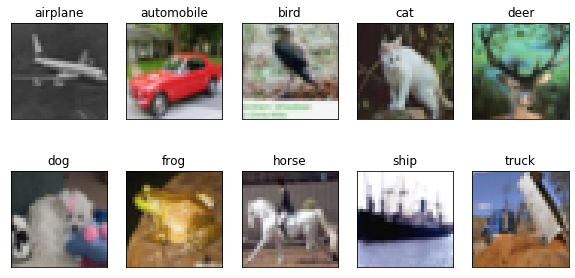

In [19]:
# checking some random images
fig = plt.figure(figsize=(10,5))
for i in range(num_classes):
  ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
  idx = np.where(y_train[:]==i)[0] # selecting image_idx of single class
  features = x_train[idx,::]
  img_num = np.random.randint(features.shape[0])
  im = features[img_num]
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

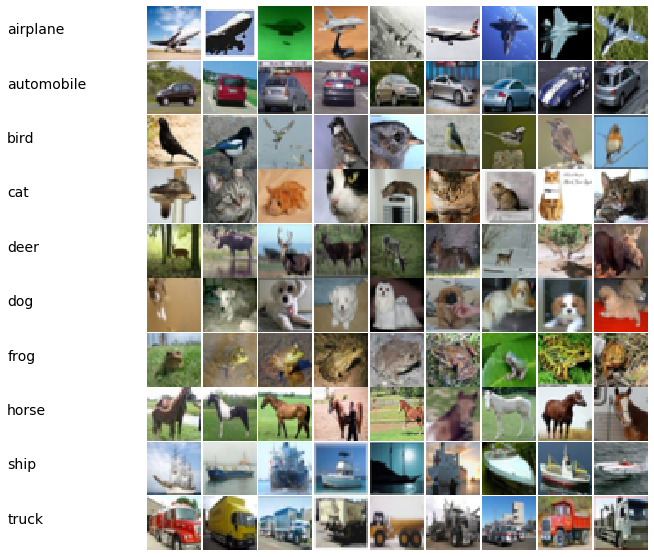

In [20]:
# display n random images for each class
n = 10
r, c = 10, n
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(y_train[:]==i)[0], c, replace=False)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, c):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(x_train[idx[j-1]], interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [0]:
version = 2

batch_size = 128  
epochs = 50
data_augmentation = True
num_classes = 10
subtract_pixel_mean = True  # Subtracting pixel mean improves accuracy


depth = 20

In [0]:
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Normalizing data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
def plot_model_history(model_history):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  # summarize history for accuracy
  ax[0].plot(range(1, len(model_history.history['acc'])+1), model_history.history['acc'])#, label='Training Acc')
  ax[0].plot(range(1, len(model_history.history['val_acc'])+1), model_history.history['val_acc'])#, label='Validation Acc')
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xticks(np.arange(1, len(model_history.history['acc'])+1), len(model_history.history['acc'])/10)
  ax[0].legend(['Train', 'Validation'], loc='best')

  # summarize history for loss
  ax[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
  ax[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
  ax[1].legend(['Train', 'Validation'], loc='best')

  plt.show()

In [0]:
def lr_schedule(epoch):
  lr =  round(0.03 * 1/(1 + 0.319 * epoch), 10)
  print ('Learning rate is : ', lr)
  return lr
# print([ lr_schedule(e) for e in range(50)])

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """
    2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [27]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = resnet_v2(input_shape=x_train.shape[1:], depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate is :  0.03
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 16)   64          conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 16)   0           batch_normalization_20[0][0]     
___________________________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [14]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model_info = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    
    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=50, verbose=1, workers=4,
                        callbacks=callbacks)


Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
Learning rate is :  0.03
391/391 [==============================] - 44s 113ms/step - loss: 1.9826 - acc: 0.3141 - val_loss: 2.0937 - val_acc: 0.2618

Epoch 00001: val_acc improved from -inf to 0.26180, saving model to /content/saved_models/cifar10_ResNet20v2_model.001.h5
Epoch 2/50
Learning rate is :  0.0227445034
391/391 [==============================] - 36s 91ms/step - loss: 1.6733 - acc: 0.4107 - val_loss: 2.7671 - val_acc: 0.2745

Epoch 00002: val_acc improved from 0.26180 to 0.27450, saving model to /content/saved_models/cifar10_ResNet20v2_model.002.h5
Epoch 3/50
Learning rate is :  0.0183150183
391/391 [==============================] - 35s 91ms/step - loss: 1.5409 - acc: 0.4738 - val_loss: 1.9163 - val_acc: 0.4074

Epoch 00003: val_acc improved from 0.27450 to 0.40740, saving model to /content/saved_models/cifar10_ResNet20v2_model.003.h5


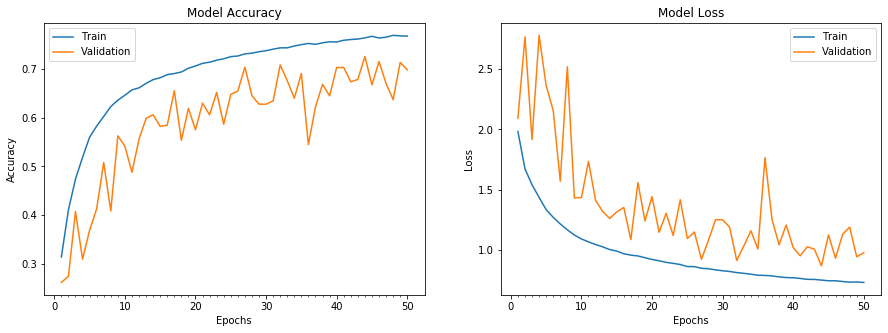

In [29]:
# plot model history
plot_model_history(model_info)

Very high fluctuations in validation loss, could be due to high learning rate as described [here](https://forums.fast.ai/t/very-volatile-validation-loss/7573/6)

The error is described very well in [this](https://stats.stackexchange.com/a/264767) stackexchange answer

> learning rate: α is too large, so SGD jumps too far and misses the area near local minima. This would be extreme case of "under-fitting" (insensitivity to data itself), but might generate (kind of) "low-frequency" noise on the output by scrambling data from the input - contrary to the overfitting intuition, it would be like always guessing heads when predicting a coin.  Arriving at the area "too close to" a minima might cause overfitting, so if α is too small it would get sensitive to "high-frequency" noise in your data. α should be somewhere in between.


Decreased learning rate and trying next model

Learning rate is :  0.03
Learning rate is :  0.0227445034
Learning rate is :  0.0183150183
Learning rate is :  0.0153295861
Learning rate is :  0.0131810193
Learning rate is :  0.0115606936
Learning rate is :  0.010295127
Learning rate is :  0.0092793071
Learning rate is :  0.0084459459
Learning rate is :  0.0077499354
Learning rate is :  0.0071599045
Learning rate is :  0.0066533599
Learning rate is :  0.0062137531
Learning rate is :  0.005828638
Learning rate is :  0.0054884742
Learning rate is :  0.0051858254
Learning rate is :  0.00491481
Learning rate is :  0.0046707146
Learning rate is :  0.0044497182
Learning rate is :  0.00424869
Learning rate is :  0.0040650407
Learning rate is :  0.0038966099
Learning rate is :  0.0037415814
Learning rate is :  0.0035984167
Learning rate is :  0.0034658041
Learning rate is :  0.0033426184
Learning rate is :  0.003227889
Learning rate is :  0.003120774
Learning rate is :  0.0030205397
Learning rate is :  0.0029265438
Learning rate is :  0.0028

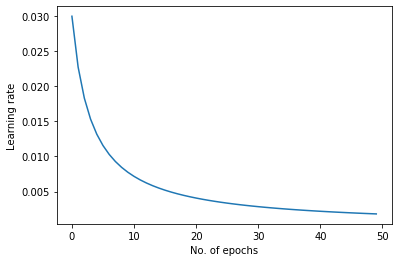

In [15]:
plt.plot([ lr_schedule(e) for e in range(50)])
plt.xlabel('No. of epochs')
plt.ylabel('Learning rate')
plt.show()